# Sinais e Sistemas Dinâmicos - Projeto final - Relatório
#### Samuel Pordeus - 11400947
#### Elcius Ferreira - 11400968

O projeto consiste em segmentar os diferentes instrumentos de uma música. Utilizamos como base a música **Come as you are - Nirvana**. Vamos demonstrar ao longo deste relatório o nosso processo de pensamento até chegarmos em uma possível solução do problema.

# 1. Fase de análise do arquivo de áudio
### Importando os módulos necessários

In [1]:
import scipy.io.wavfile
import pydub
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
from pydub import AudioSegment
from pydub.playback import play

%matplotlib inline

Abaixo importamos a música que vai ser processada pelo programa utilizando o módulo SciPy:


In [2]:
rate,audData=scipy.io.wavfile.read("wav/nirvana.wav")

Checando o tamanho da música em segundos:

In [3]:
length = audData.shape[0] / rate
length

225.69795918367348

Aqui temos de separar a música em dois canais, pois ela é Stereo. Optamos por não transformar o áudio em mono, pois ao utilizar o recurso da SciPy para isto, causamos um grande dano ao arquivo de áudio, depois da fase de análise, utilizaremos a biblioteca pydub para realizar esta tarefa.

In [4]:
channel1=audData[:,0] #left
channel2=audData[:,1] #right

Checando algumas propriedades do arquivo de som, respectivamente, o tipo de variável e a energia do arquivo de áudio:

In [5]:
audData.dtype

dtype('int16')

In [6]:
np.sum(channel1.astype(float)**2)

50712767452163.0

### Amplitude de som vs Tempo

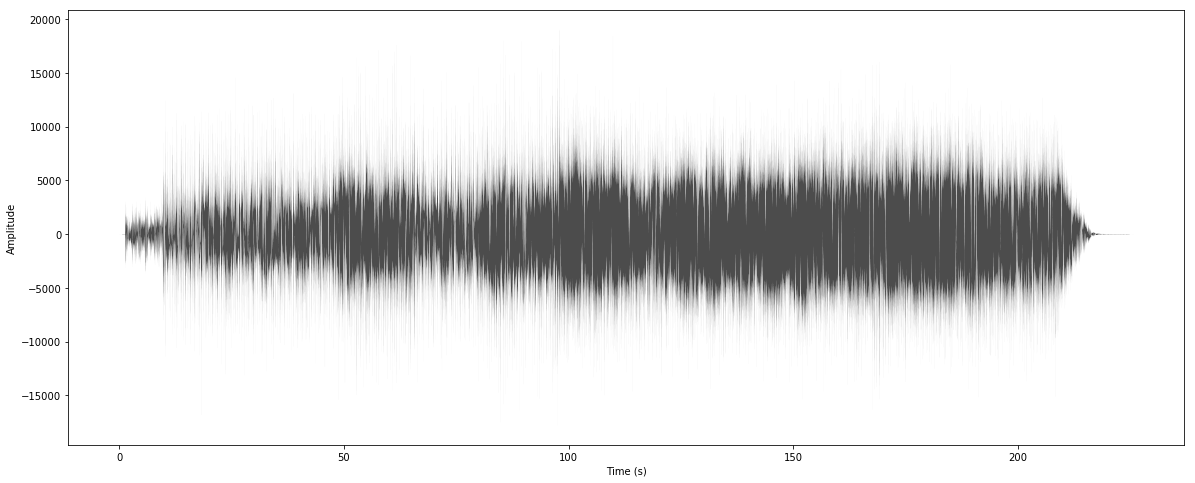

In [28]:
#create a time variable in seconds
time = np.arange(0, float(audData.shape[0]), 1) / rate

#plot amplitude (or loudness) over time
plt.figure(1, figsize=(20,8))
plt.plot(time, channel1, linewidth=0.01, alpha=0.7, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Utilizando a fast fourier transform no arquivo de som

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


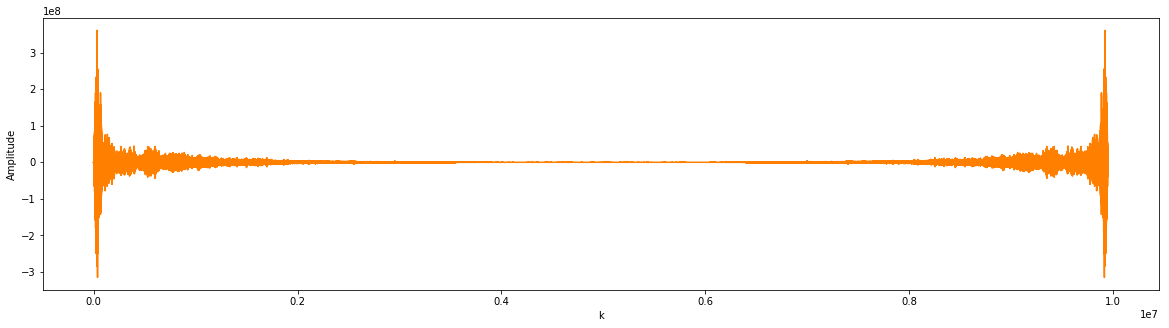

In [29]:
from numpy import fft as fft

fourier=fft.fft(channel1)

plt.figure(1, figsize=(20,5))
plt.plot(fourier, color='#ff7f00')
plt.xlabel('k')
plt.ylabel('Amplitude')

# Plotando dB vs kHz

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


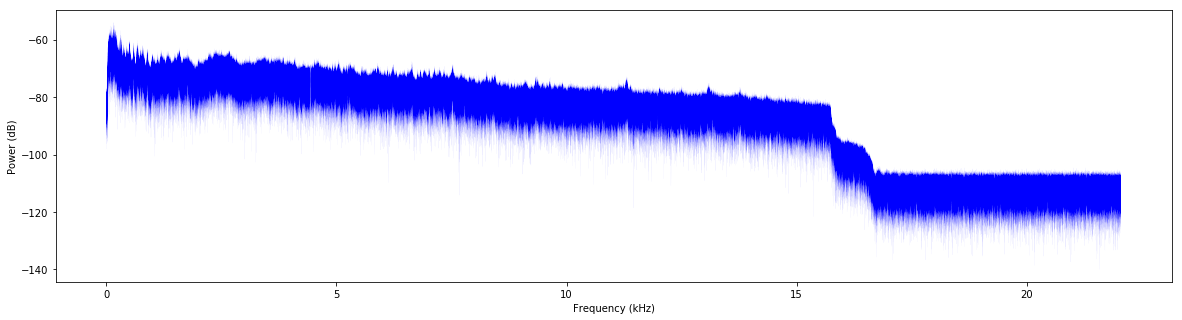

In [33]:
n = len(channel1)

fourier = fourier[0:int(n/2)]
fourier = fourier / float(n)
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);

plt.figure(1, figsize=(20,5))
plt.plot(freqArray/1000, 10*np.log10(fourier), color ='blue', linewidth=0.02)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (dB)')

# Spectrograma

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7222: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


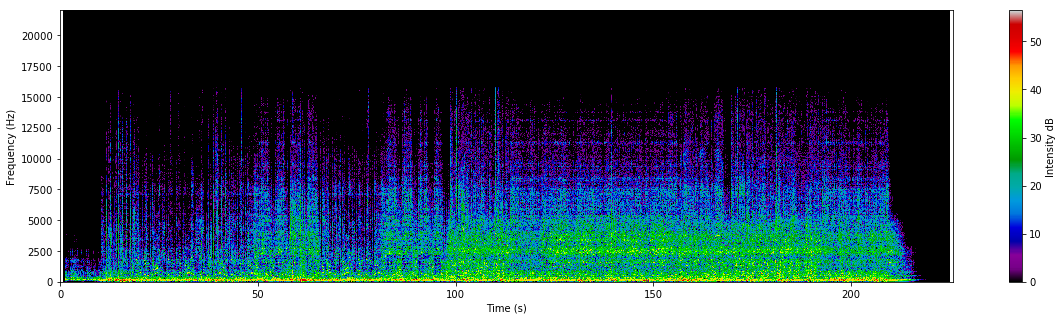

In [31]:
plt.figure(1, figsize=(20,5))
Pxx, freqs, bins, im = plt.specgram(channel1, Fs=rate, vmin=0, NFFT=1024, cmap=plt.get_cmap('nipy_spectral'), window=mlab.window_hanning)
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity dB')
# plt.axis([0, length, 0, 7500])
# plt.savefig("/home/samuelspordeus/fft.pdf", dpi = 200)

# Zoom nas frequencias mais baixas

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7222: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


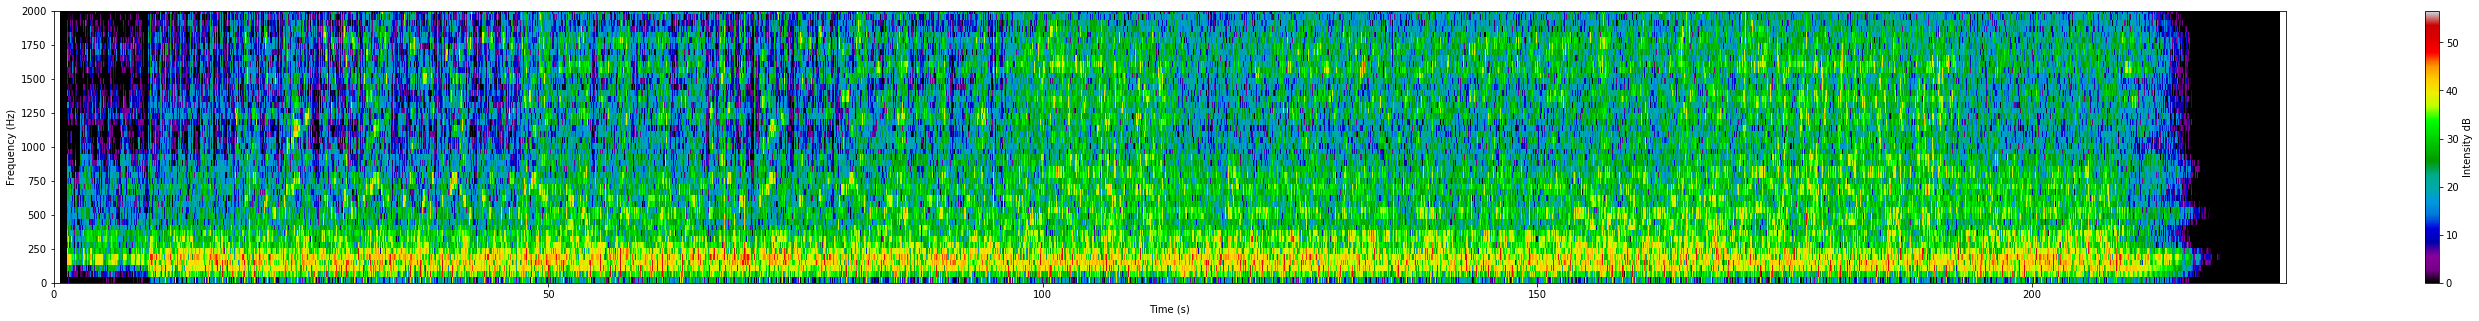

In [34]:
plt.figure(1, figsize=(50,5))
Pxx, freqs, bins, im = plt.specgram(channel1, Fs=rate, vmin=0, NFFT=1024, cmap=plt.get_cmap('nipy_spectral'), window=mlab.window_hanning)
cbar=plt.colorbar(im)
plt.axis([0, length, 0, 2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity dB')
# plt.savefig("/home/samuelspordeus/speczoom.png", dpi = 400)

# Mapeando frequências entre 430 e 1076

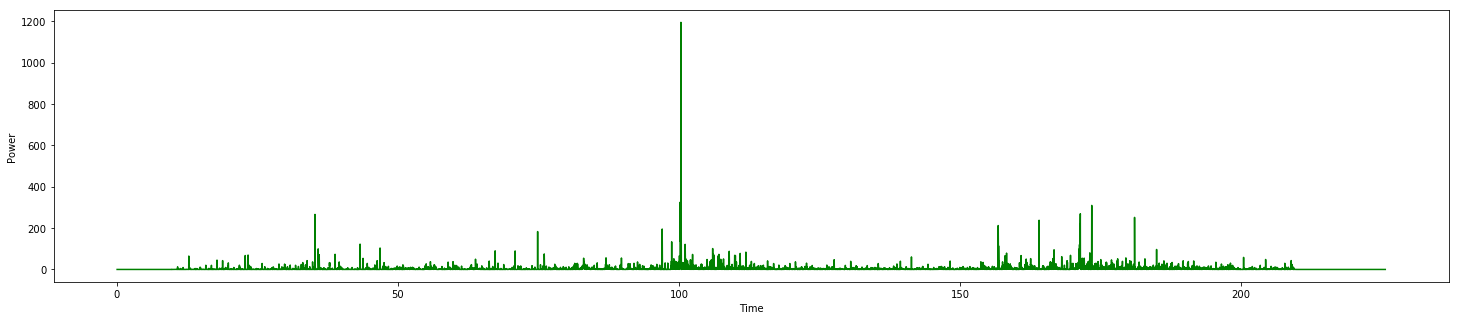

In [35]:
plt.figure(1, figsize=(25,5))
np.where(np.logical_and(freqs>=430.6640625, freqs<=1076.66015625))
MHZ10=Pxx[233,:]
plt.xlabel('Time')
plt.ylabel('Power')
plt.plot(bins, MHZ10, color='green')

# 2. Filtros

## Segmentação da voz
Informações que temos ao nosso favor:
* Sabemos, lendo estudos realizados em cima das músicas de Nirvana, que a voz de Kurt Cobain tem um range de 61hz 1046hz, pois ele vai de B1 a C6 em notas musicais.
* Dificilmente a voz de um cantor masculino passa de 1000hz, mas, pelo que analisamos no spectrograma da nossa Sample, boa parte do tempo a voz do cantor fica numa faixa mais central, entre 500-700.

Utilizamos um filtro passa-baixo, utilizando como frequencia de corte um valor que achamos o ideal após analisarmos cuidadosamente o spectograma e conseguirmos discernir em que faixa estava a voz de Kurt.

## Aplicando filtros

Normalizaremos a amplitude e utilizaremos um filtro de banda para separarmos a voz.

In [7]:
channel1 = np.divide(channel1, 2**16)

In [8]:
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.io import wavfile

signal = channel1

W = fftfreq(signal.size, d=1/44100)

f_signal = rfft(signal)

cut_f_signal = f_signal.copy()
cut_f_signal[(W < 4000)] = 0
cut_f_signal[(W > 6000)] = 0
cut_signal = irfft(cut_f_signal)

wavfile.write('filtered_voice.wav', rate=44100, data=cut_signal)

## Filtrando o baixo

In [10]:
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.io import wavfile

signal = channel1

W = fftfreq(signal.size, d=1/44100)

f_signal = rfft(signal)

cut_f_signal = f_signal.copy()
cut_f_signal[(W > 500)] = 0
cut_signal = irfft(cut_f_signal)

wavfile.write('filtered_baixo.wav', rate=44100, data=cut_signal)

### O arquivo de output foi salvo na mesma pasta que esse ipynb se encontra com o nome: *filtered.wav*

## Spectrograma da faixa de áudio do vocal

In [54]:
new_rate,new_audData=scipy.io.wavfile.read("filtered_voice.wav")

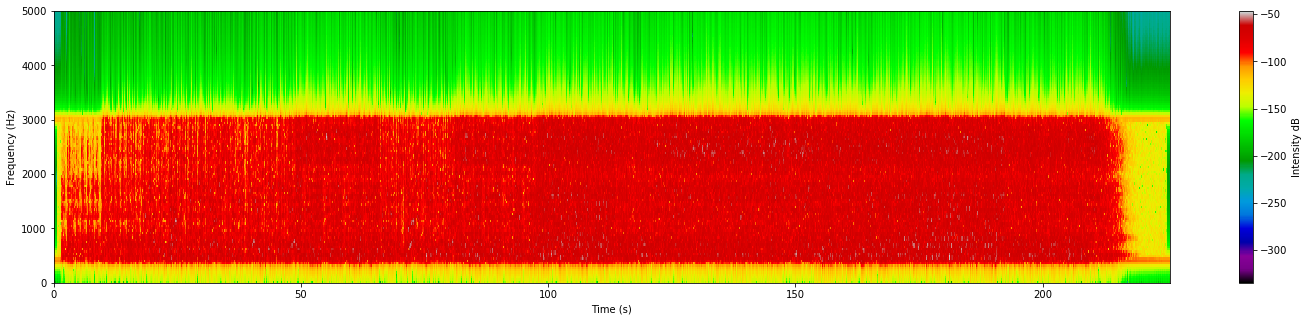

In [57]:
plt.figure(1, figsize=(25,5))
Pxx, freqs, bins, im = plt.specgram(new_audData, Fs=new_rate, NFFT=1024, cmap=plt.get_cmap('nipy_spectral'), window=mlab.window_hanning)
cbar=plt.colorbar(im)
plt.axis([0, length, 0, 5000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity dB')
# plt.savefig("/home/samuelspordeus/fft.pdf", dpi = 200)

## Spectrograma do arquivo de áudio do baixo

In [48]:
new_rate,new_audData=scipy.io.wavfile.read("filtered_baixo.wav")

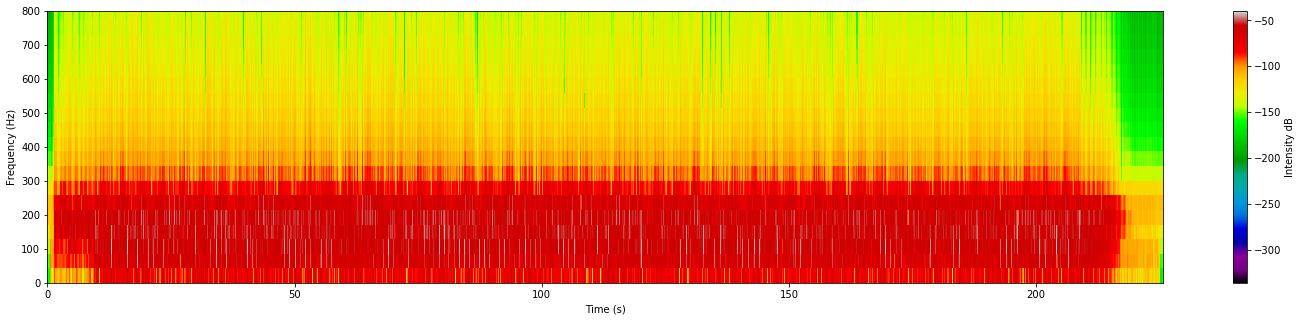

In [53]:
plt.figure(1, figsize=(25,5))
Pxx, freqs, bins, im = plt.specgram(new_audData, Fs=new_rate, NFFT=1024, cmap=plt.get_cmap('nipy_spectral'), window=mlab.window_hanning)
cbar=plt.colorbar(im)
plt.axis([0, length, 0, 800])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity dB')
# plt.savefig("/home/samuelspordeus/fft.pdf", dpi = 200)

## Formas de aumentar a precisão
Não encontramos uma maneira linear de filtrar/segmentar instrumentos musicais, porém pensamos em uma maneira muito interessante de separar os instrumentos de uma música:

Utilizando aprendizado de máquina não-supervisionado, com uma clusterização para separar as diferentes faixas de frequências que contivessem instrumentos. Tendo *samples* destes instrumentos como modelos de treinamento, poderiamos tentar filtrar qualquer música. Entretanto, um trabalho de tamanha complexidade seria digno de um TCC.

## Considerações finais
Tivemos uma grande 'ajuda' do Spectrograma na ajustagem do parâmetro da frequencia de corte para separarmos o arquivo com a voz, outros instrumentos são possíveis de serem segmentados com uma análise prévia do spectrograma da música.

Dito isso tudo, aprendemos bastante sobre filtros, pois tivemos que estudar muitos conceitos aprendidos em sala, que nos pareciam distantes da realidade, novamente. Vê-los sendo aplicados na prática edificou o nosso conhecimento no assunto.